In [1]:
import spectral.io.envi as envi
from proj.tasks import send_matrix_to_queue_task, read_image_spectral, clf_RF_1, read_col_data_from_file
import numpy as np
import pandas as pd
import sqlite3
from concurrent.futures import ThreadPoolExecutor, as_completed
import os
import json
from datetime import datetime
import time
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colormaps
import time 

In [2]:
img = read_image_spectral()

In [3]:
img

	Data Source:   './../data/spectral_image/hyper_20220913_3cm.img'
	# Rows:           6478
	# Samples:        5287
	# Bands:           122
	Interleave:        BSQ
	Quantization:   8 bits
	Data format:     uint8

In [4]:
NUM_ROW, NUM_COL, NUM_BAND = img.shape

In [5]:
NUM_ROW

6478

In [6]:
NUM_COL

5287

In [7]:
def col_data(col):
    file_path = f"./data/img_col_data/img_{col}.npz"
    return read_col_data_from_file(file_path)

In [8]:
col_3000 = col_data(3000)

In [9]:
col_3000

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [10]:
BANDS_ZERO = np.zeros((122), dtype=np.uint8)

In [11]:
BANDS_ZERO

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8)

In [12]:
col_3000[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8)

In [13]:
compare = col_3000[col_3000 == BANDS_ZERO]

In [14]:
compare.shape

(119529,)

In [15]:
a = np.array([
	[1, 2, 3],
	[1, 2, 3],
	[1, 2, 4],
])

In [16]:
b = np.array([1, 2, 3])

In [17]:
a[a == b]

array([1, 2, 3, 1, 2, 3, 1, 2])

In [18]:
df = pd.DataFrame()

In [19]:
print(df)

Empty DataFrame
Columns: []
Index: []


In [20]:
matching_rows = np.where(np.all(a == b, axis=1))

In [21]:
matching_rows

(array([0, 1]),)

In [22]:
matching_rows = np.where(np.all(col_3000 == BANDS_ZERO, axis=1))

In [23]:
len(matching_rows[0])

978

In [24]:
col_3000[145]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8)

In [25]:
matching_rows[0]

array([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
         11,   12,   13,   14,   15,   16,   17,   18,   19,   20,   21,
         22,   23,   24,   25,   26,   27,   28,   29,   30,   31,   32,
         33,   34,   35,   36,   37,   38,   39,   40,   41,   42,   43,
         44,   45,   46,   47,   48,   49,   50,   51,   52,   53,   54,
         55,   56,   57,   58,   59,   60,   61,   62,   63,   64,   65,
         66,   67,   68,   69,   70,   71,   72,   73,   74,   75,   76,
         77,   78,   79,   80,   81,   82,   83,   84,   85,   86,   87,
         88,   89,   90,   91,   92,   93,   94,   95,   96,   97,   98,
         99,  100,  101,  102,  103,  104,  105,  106,  107,  108,  109,
        110,  111,  112,  113,  114,  115,  116,  117,  118,  119,  120,
        121,  122,  123,  124,  125,  126,  127,  128,  129,  130,  131,
        132,  133,  134,  135,  136,  137,  138,  139,  140,  141,  142,
        143,  144,  145,  146,  147,  148,  149,  1

In [26]:
col_3000[matching_rows[0]]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [27]:
def get_position_of_bands_zero(col_data):
    matching_rows = np.where(np.all(col_data == BANDS_ZERO, axis=1))
    return matching_rows[0]

In [28]:
def predict_nitos_for_img(saved_result_path):
    if os.path.exists(saved_result_path):
        print(f"File {saved_result_path} already exists.")
        with np.load(saved_result_path) as file:
            return file["arr_0"]
    
    print(f"File {saved_result_path} NOT exists.")
    nitos = np.zeros((NUM_ROW, NUM_COL))
    for col in range(NUM_COL):
        if col % 100 == 0:
            print(col)
        file_path = f"./data/img_col_data/img_{col}.npz"
        bands = read_col_data_from_file(file_path)
        nitos[:, col] = clf_RF_1.predict(bands)
        band_zeros_position = get_position_of_bands_zero(bands)
        nitos[band_zeros_position, col] = 0
    np.savez_compressed(saved_result_path, nitos)
    return nitos

In [29]:
nitos = predict_nitos_for_img("./data/saved_result/nitos.npz")

File ./data/saved_result/nitos.npz already exists.


In [30]:
nitos.shape

(6478, 5287)

In [31]:
def draw(result, file_output, color_map):
    # Assuming 'assigned_values' is your array with assigned values for each pixel
    # Replace this with your actual data
    assigned_values = np.random.randint(0, 255, size=(100, 100))

    # Define a colormap (you can choose any colormap from matplotlib)
    cmap = color_map

    # Create a figure and axis
    fig, ax = plt.subplots()

    # Display the image with the assigned colors
    im = ax.imshow(result, cmap=cmap)

    # Add a colorbar to the right of the plot
    cbar = fig.colorbar(im, ax=ax)

    # Show the plot
    # plt.gcf().savefig(file_output)
    plt.show()
    

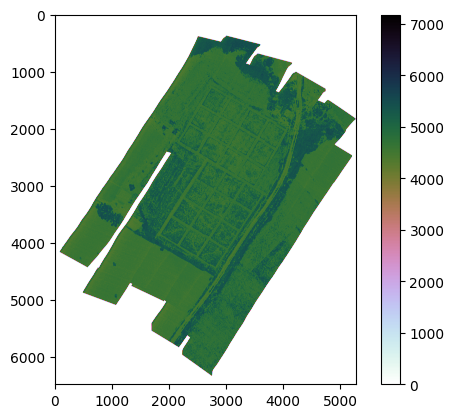

In [32]:
draw(nitos, "./output_image/nito/nito1.png", "cubehelix_r")

In [33]:

list_cmap = list(colormaps)

In [34]:
# for cmap in list_cmap:
#     print(cmap)
#     draw(nitos, "./output_image/nito/nito1.png", cmap)

In [35]:


# Define the colors and their positions along the colormap
colors = [(0, 'blue'),     # Start color (position 0)
          (0.5, 'green'),  # Middle color (position 0.5)
          (0.51, 'yellow'),# Custom color for the range 5000-6000 (position 0.51)
          (1, 'red')] 

In [36]:
cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)

In [37]:
viridis = mpl.colormaps['viridis']

In [38]:
cmap = ListedColormap(["darkorange", "gold", "lawngreen", "0"])

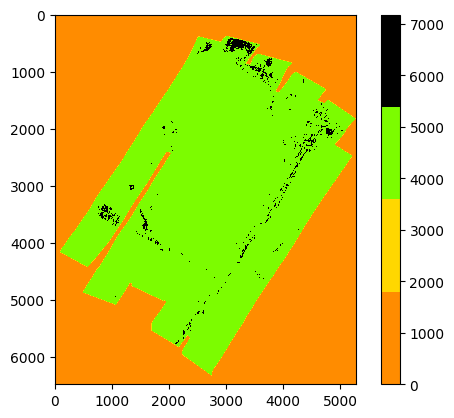

In [39]:
draw(nitos, "./", cmap)

In [40]:
number_color = 8000

In [41]:
tab20c = mpl.colormaps['tab20c'].resampled(number_color)

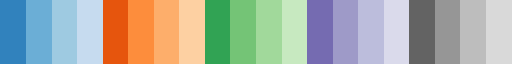

In [42]:
tab20c

In [43]:
newcolors_tab20c = tab20c(np.linspace(0, 1, number_color))

In [44]:
def get_color_value(r, g, b, a):
    return [r/256, g/256, b/256, a]

In [45]:
newcolors_tab20c[0:400, :] = np.array(get_color_value(255, 255, 255, 1))
newcolors_tab20c[400:4800, :] = np.array(get_color_value(157, 157, 157, 1))
newcolors_tab20c[4800:5000, :] = np.array(get_color_value(215, 177, 154, 1))
newcolors_tab20c[5000:5200, :] = np.array(get_color_value(215, 177, 154, 1))
newcolors_tab20c[5200:5600, :] = np.array(get_color_value(180, 255, 71, 1))
newcolors_tab20c[5600:6000, :] = np.array(get_color_value(149, 215, 111, 1))
newcolors_tab20c[6000:6400, :] = np.array(get_color_value(0, 162, 24, 1))
newcolors_tab20c[6400:6800, :] = np.array(get_color_value(43, 153, 89, 1))
newcolors_tab20c[6800:7200, :] = np.array(get_color_value(43, 153, 123, 1))
newcolors_tab20c[7200:7600, :] = np.array(get_color_value(22, 185, 141, 1))
newcolors_tab20c[7600:8000, :] = np.array(get_color_value(3, 4, 143, 1))


In [46]:
# rgba(176, 194, 192, 0.65)

In [47]:
newcolors_tab20c.shape

(8000, 4)

In [48]:
newcmp_tab20c = ListedColormap(newcolors_tab20c)

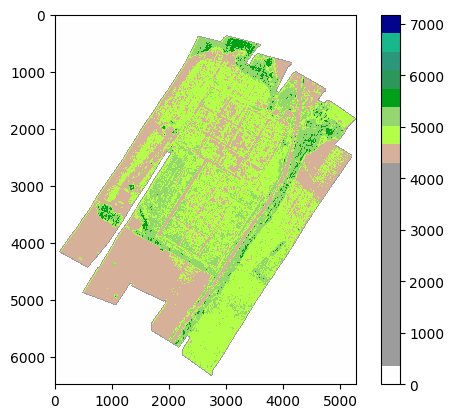

In [49]:
draw(nitos, "", newcmp_tab20c)

In [50]:
nitos[3931, 2680]

4475.404342041015

In [51]:
nitos[3761, 2354]

4180.033580322266

In [52]:
nitos[4043, 2157]

5171.547022705078

In [53]:
nitos[3431, 2561]

4448.798817138671

In [54]:
nitos[4976, 4383]

0.0

In [55]:
np.max(nitos)

7180.289520263672

In [56]:
np.min(nitos)

0.0